In [1]:
# Imports
%matplotlib inline
from os.path import join
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from multiprocessing import Pool
import numpy as np
import librosa
from tqdm import tqdm

from time import time
import matplotlib.cm as cm
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score

import pickle

In [2]:
data_root = 'drumData'
drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
drumSamples = {}
for d in drumNames:
    drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))

In [3]:
drumLabels = []
for i, drum_name in enumerate(drumNames):
    file_path = './drumFeatures/' + drum_name + '_' + 'stft' + '.npy'
    STFT_feat = np.load(file_path)
    drumLabels.extend([i] * STFT_feat.shape[0])
y_data_labels = np.asarray(drumLabels)

In [4]:
import itertools
def concatColors(segmentList, colorList):
    multiples = []
    for i in range(len(segmentList)):
        multiples.append([colorList[i]]*segmentList[i])
    return list(itertools.chain(*multiples))

colors = ['#000000', '#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff']
drumLengths = [5158,422,2546,1324,159,228,723]
colorMap = concatColors(drumLengths, colors)

In [5]:
def computeSilCoeff(data, cluster_labels):
    silhouette_avg = silhouette_score(data, cluster_labels)
    return silhouette_avg

In [6]:
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, MultiPolygon, Point

def clusterGeometryMetrics(drum_points, labels):
    grouped_drum_points = {}
    
    for i in range(len(drum_points)):
        if labels[i] not in grouped_drum_points:
            grouped_drum_points[labels[i]] = list()
        grouped_drum_points[labels[i]].append(drum_points[i])
    
    num_labels = len(grouped_drum_points)
    drum_polygons = {}
    
    for drum in grouped_drum_points:
        points = grouped_drum_points[drum]
        hull = ConvexHull(grouped_drum_points[drum])
        drum_polygons[drum] = Polygon([points[v] for v in hull.vertices])
    
    total_hull = ConvexHull(drum_points)
    total_polygon = Polygon([drum_points[v] for v in total_hull.vertices])
    p = [Point(c) for c in total_polygon.exterior.coords]
    total_diameter = max([p1.distance(p2) for p1 in p for p2 in p])
    
    calc_intersect = lambda i, j: drum_polygons[i].intersection(drum_polygons[j]).area / total_polygon.area
    calc_roundness = lambda poly : 4 * np.pi * poly.area / (poly.length**2)
    calc_distance = lambda i, j: drum_polygons[i].distance(drum_polygons[j]) / total_diameter
    
    #overlap areas between the polygons of the different clusters, normalized by area of total plot polygon
    pairwise_intersect_areas = [[calc_intersect(i,j) for i in range(num_labels)] for j in range(num_labels)]
    
    
    # Distance between nearest points of 2 polygons normalized by "diameter" of total plot polygon
    pairwise_distances = [[calc_distance(i,j) for i in range(num_labels)] for j in range(num_labels)]
    
    #measure of "roundness" of each polygon based on Polsby-Popper Test
    roundness = [calc_roundness(drum_polygons[d]) for d in drum_polygons]
    roundness_np = np.asarray(roundness)
    roundness_mean = np.mean(roundness_np)
    
    #relative sizes of each cluster polygon normalized by area of total plot polygon
    relative_areas = [drum_polygons[d].area / total_polygon.area for d in drum_polygons]
    
   #the polygons themselves for further processing 
    polygons = drum_polygons.values() + [total_polygon]
    
    #the area of the union of all cluser polygons over the area of the total plot
    overlap_ratio = reduce(lambda a,b: a.union(b), polygons[1:], polygons[0]).area / sum([p.area for p in polygons])
    
    returnVal = {}
    returnVal['pairwise_intersect_areas'] = pairwise_intersect_areas
    returnVal['roundness'] = roundness
    returnVal['roundness_mean'] = roundness_mean
    returnVal['relative_areas'] = relative_areas
    returnVal['overlap_ratio'] = overlap_ratio
    returnVal['polygons'] = polygons
    returnVal['pairwise_distances'] = pairwise_distances
    return returnVal

In [7]:
def evalMetrics(data, cluster_labels):
    silhouette_score = computeSilCoeff(data, cluster_labels)
    geometry_dict = clusterGeometryMetrics(data, cluster_labels)
    final_score = silhouette_score + geometry_dict['roundness_mean'] + geometry_dict['overlap_ratio']
    return (silhouette_score,geometry_dict['roundness_mean'],geometry_dict['overlap_ratio'],final_score)

In [8]:
def loadFeature(feature_name):
    drum_features = []
    for drum_name in drumNames: 
        file_path = './drumFeatures/' + drum_name + '_' + feature_name + '.npy'
        drum_feature = np.load(file_path)
        drum_features.extend(drum_feature)
    drum_features = np.asarray(drum_features)
    #print(feature_name + " original dim", drum_features.shape)
    print('%-9s\t%s' % (feature_name, drum_features.shape))
    drum_features = drum_features.reshape(len(drum_features),-1)
    return drum_features

def loadAllFeatures(feature_dict):   
    x_data_features = {}
    for feature_name in feature_dict:
        drum_features = loadFeature(feature_name)
        x_data_features[feature_name] = drum_features
    return x_data_features

In [9]:
# Define some pretty printing
print('feature_name\t original dimensions')
print('_'*35)

# Load all the features
feature_list = ['stft','mfcc','mir','wavenet']
x_data_dict = loadAllFeatures(feature_list)

feature_name	 original dimensions
___________________________________
stft     	(10560, 32, 32)
mfcc     	(10560, 30, 24)
mir      	(10560, 6, 24)
wavenet  	(10560, 23, 16)


In [10]:
def get_scaled_umap_embeddings(features, neighbour, distance):
    
    embedding = umap.UMAP(n_neighbors=neighbour,
                          min_dist=distance,
                          metric='correlation').fit_transform(features)
    scaler = MinMaxScaler()
    scaler.fit(embedding)
    return scaler.transform(embedding)

def gridSearchUMAP(x_data):
    umap_embeddings = []
    neighbours = [5, 10, 15, 30, 50]
    distances = [0.000, 0.001, 0.01, 0.1, 0.5]
    for i, neighbour in enumerate(neighbours):
        for j, distance in enumerate(distances):
            start_time = time.time()
            print("neighbour: ",neighbour,"distance",distance)
            %time umap_embedding = get_scaled_umap_embeddings(x_data, neighbour, distance)
            umap_embeddings.append(umap_embedding)
    return umap_embeddings

def gridSearchUMAPallFeatures(x_data_dict):
    umap_data_dict = {}
    feature_list = ['stft','mfcc','mir','wavenet']
    for feature_name in feature_list:
        umap_data_dict[feature_name] = gridSearchUMAP(x_data_dict[feature_name])
    return umap_data_dict

In [11]:
import time
import umap

def gridSearchPCAUMAP(x_data):
    pca_umap_dict = {}
    pca_dims = [2,4,6,8,10,12,14,16,20,22]
    for key in pca_dims:
        pca_umap_dict[key] = {}
    
    for i, pca_dim in enumerate(pca_dims):
        start_time = time.time()
        reduced_data = PCA(n_components=pca_dim).fit_transform(x_data)
        embedding = get_scaled_umap_embeddings(reduced_data, 50, 0.5)
        end_time = time.time() - start_time
        (s_score, r_score, o_score, f_score) = evalMetrics(embedding, y_data_labels)
        pca_umap_dict[pca_dim]['embedding'] = embedding
        pca_umap_dict[pca_dim]['time'] = end_time
        pca_umap_dict[pca_dim]['score'] = f_score
        print(pca_dim, end_time, f_score)
    return pca_umap_dict

In [12]:
pca_umap_dict = gridSearchPCAUMAP(x_data_dict['stft'])

(2, 31.36359715461731, 1.0058101632387928)
(4, 19.66721510887146, 1.0709916610851153)
(6, 17.721108198165894, 1.1114467205533942)
(8, 17.627202033996582, 1.1314679515467352)
(10, 17.3332359790802, 1.1300460008177495)
(12, 18.117056846618652, 1.1195352234709173)
(14, 17.27184820175171, 1.1705987673411684)
(16, 17.260608911514282, 1.1612207997490738)
(20, 17.636465072631836, 1.1367510116965767)
(22, 17.689089059829712, 1.1302706133952523)


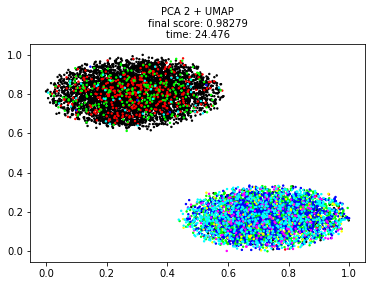

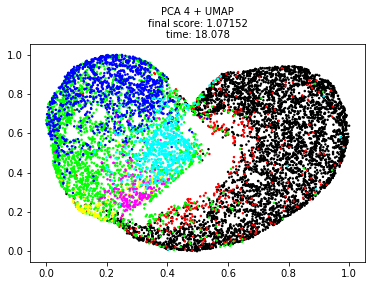

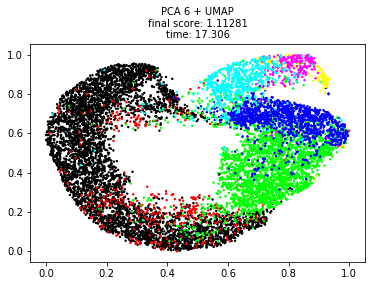

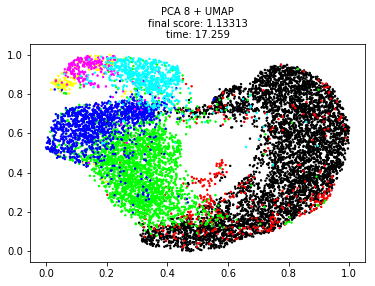

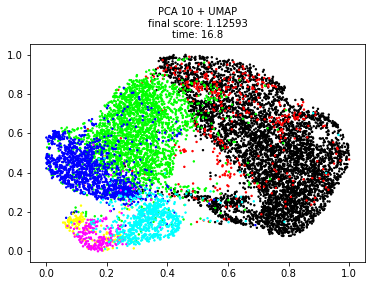

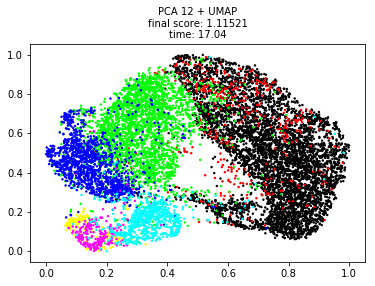

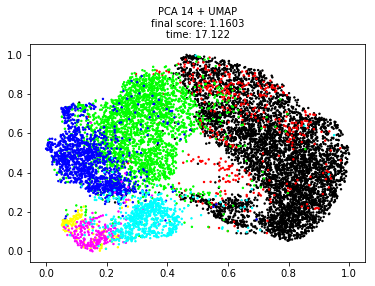

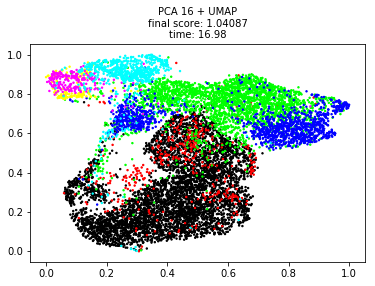

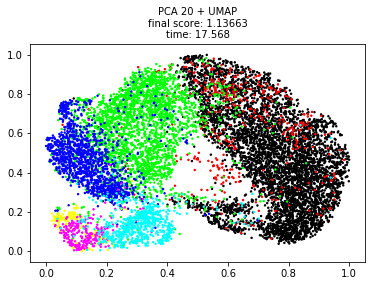

In [36]:
pca_dims = [2,4,6,8,10,12,14,16,20,22]

for pca_dim in pca_dims:
    plt.figure()
    embedding = pca_umap_dict[pca_dim]['embedding']
    time = pca_umap_dict[pca_dim]['time']
    score = pca_umap_dict[pca_dim]['score']
    
    plt.scatter(embedding.T[0], 
                    embedding.T[1], 
                    c=colorMap,
                    s=2)      
    plt.title("PCA " + str(pca_dim) + " + UMAP" + "\nfinal score: " + str(round(score,5)) + "\ntime: " + str(round(time,3)), fontdict={'fontsize': 10})

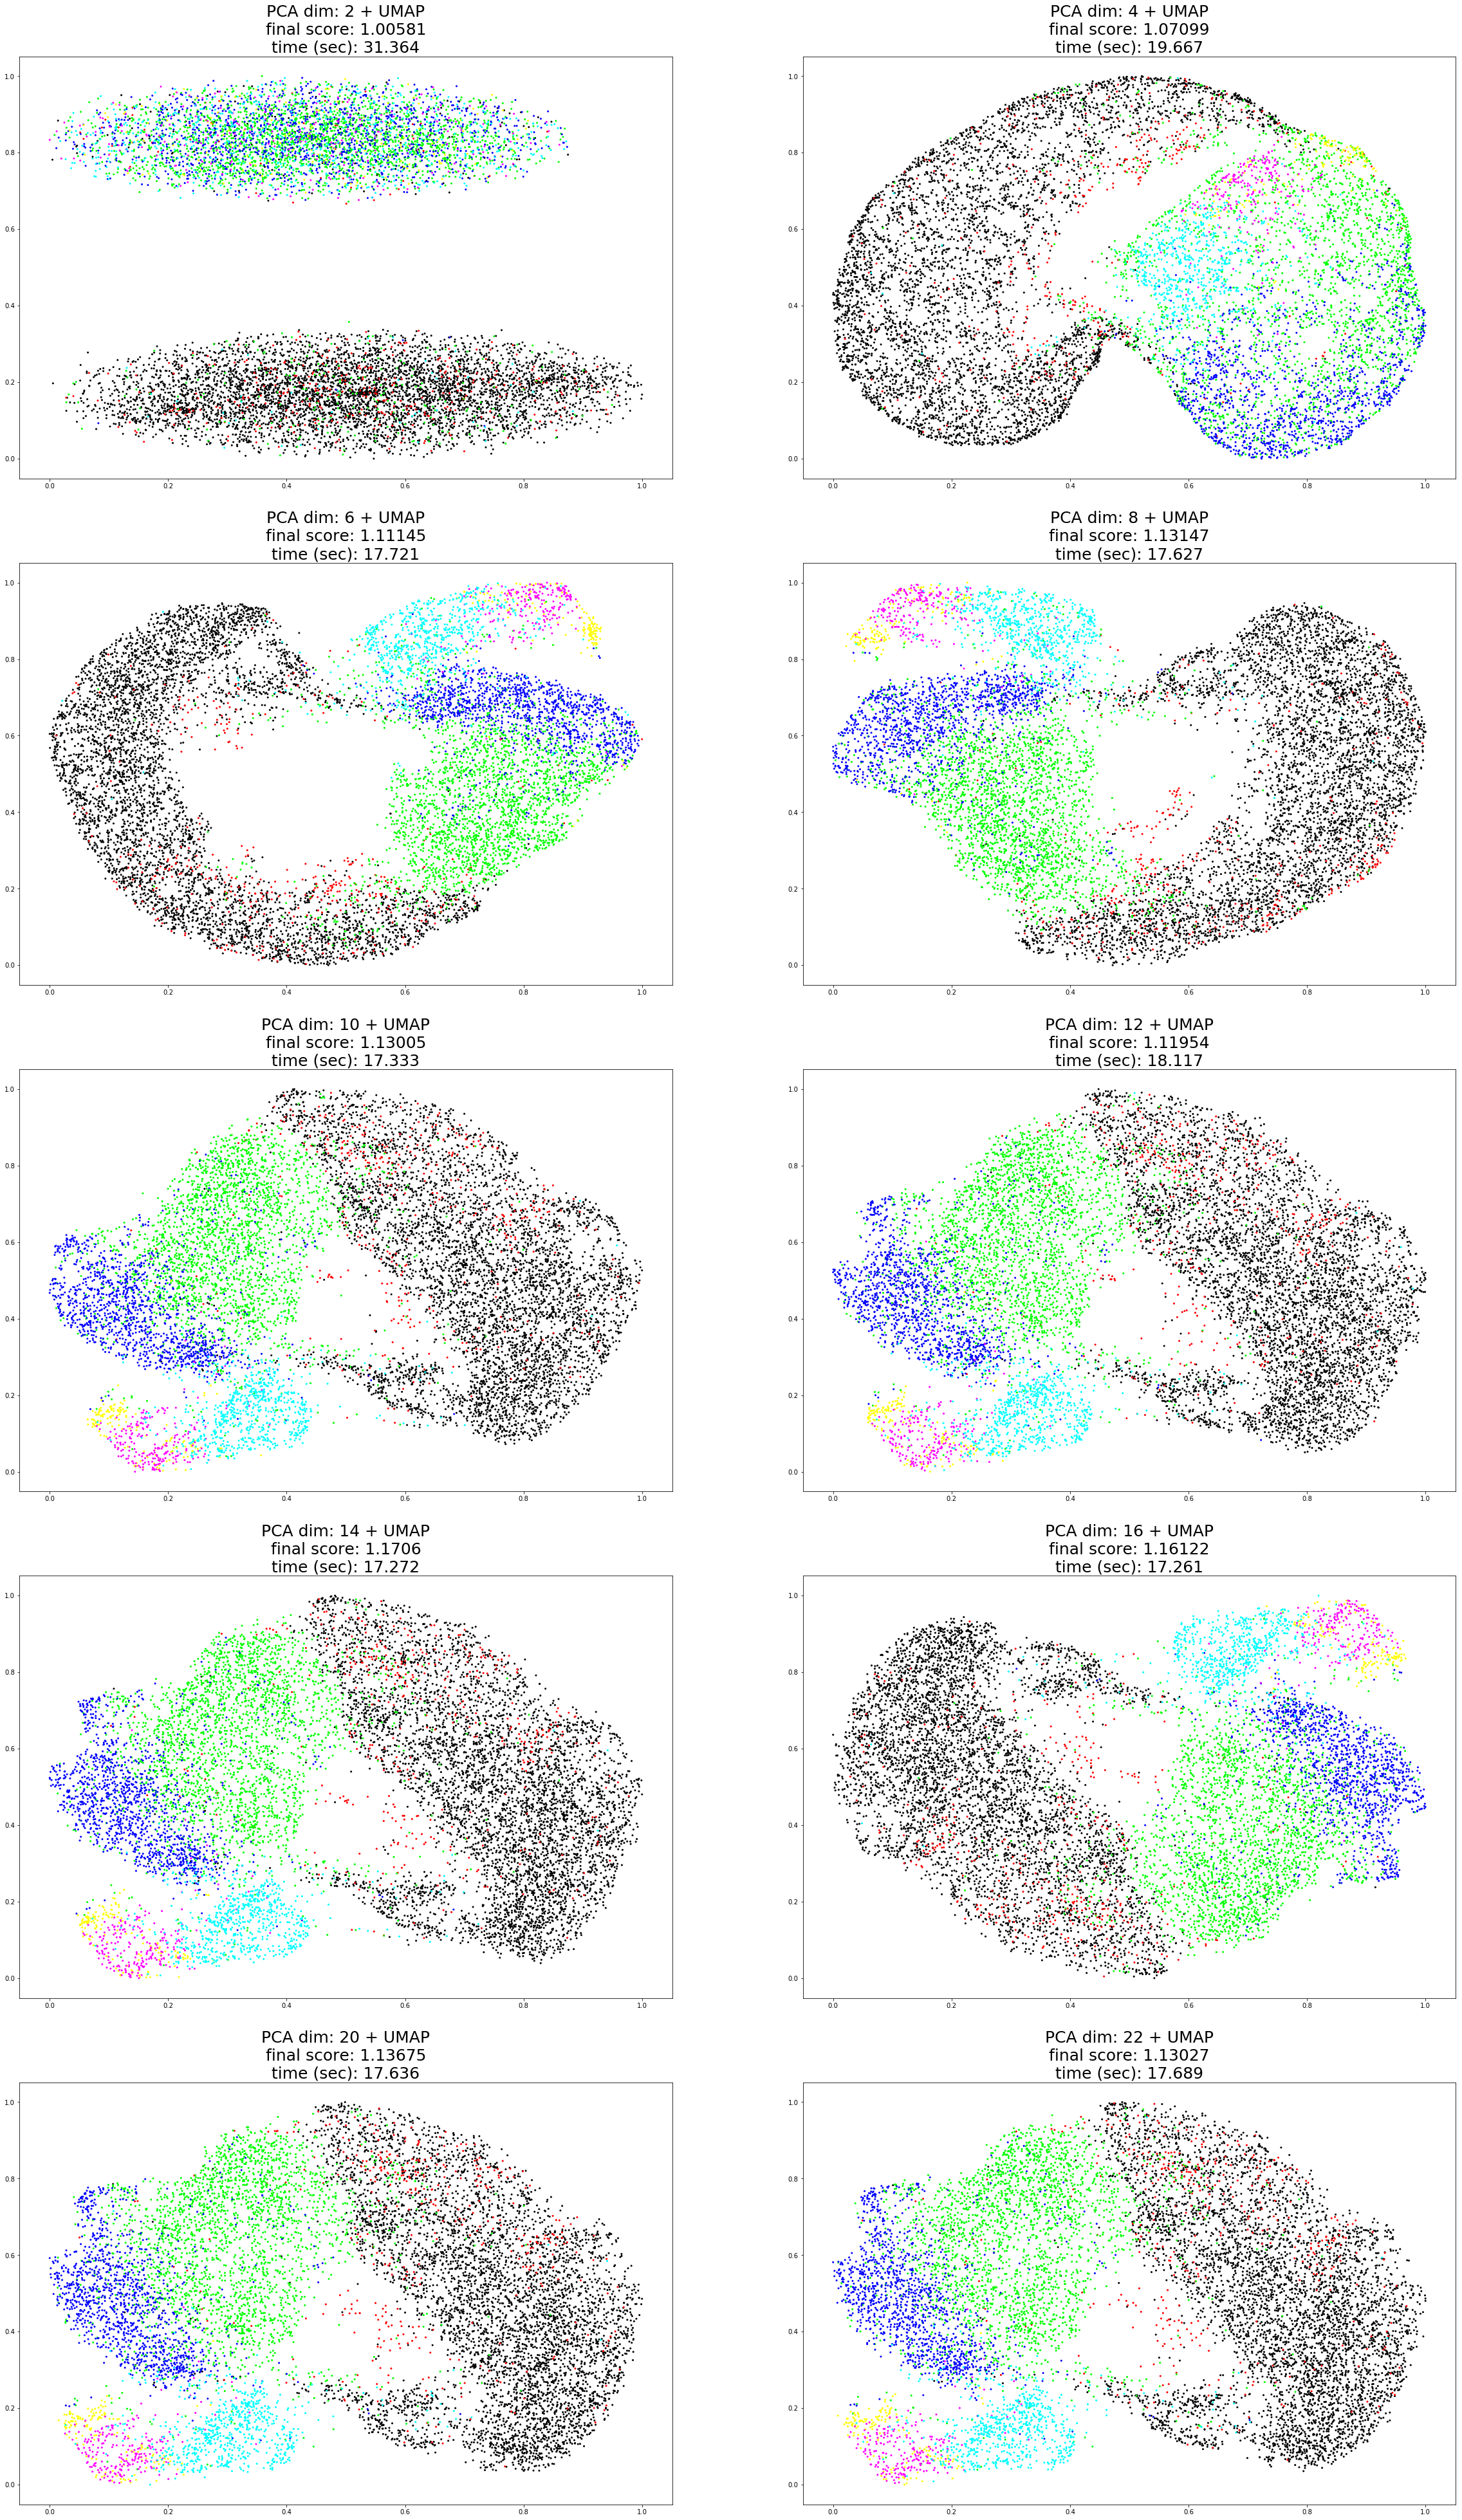

In [28]:
fig, ax = plt.subplots(nrows=5, 
                   ncols=2,
                   figsize=(40, 70))

pca_dims = [2,4,6,8,10,12,14,16,20,22]

for row_idx, row in enumerate(ax):
    for col_idx, col in enumerate(row):
        current_plot = row_idx * 2 + col_idx
        #print(row_idx, col_idx, current_plot)
        pca_dim = pca_dims[current_plot]
        
        embedding = pca_umap_dict[pca_dim]['embedding']
        time = pca_umap_dict[pca_dim]['time']
        score = pca_umap_dict[pca_dim]['score']
        
        col.scatter(embedding.T[0], 
                    embedding.T[1], 
                    c=colorMap,
                    s=4)      
        col.set_title("PCA dim: " + str(pca_dim) + " + UMAP" + "\nfinal score: " + str(round(score,5)) + "\ntime (sec): " + str(round(time,3)), fontdict={'fontsize': 25})

In [25]:
import time
start_time = time.time()
mir_umap_embedding = get_scaled_umap_embeddings(x_data_dict['mir'], 50, 0.05)
end_time = time.time() - start_time
print(end_time)

23.4100739956


In [26]:
def plot2D(reduced_data, colorMap, dim_red_type, feature):
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1],c=colorMap,s=2)
    plt.title(dim_red_type + " on " + feature)
    plt.show()

def printMetrics(scores):
    print('metric\t\t score')
    print('_' * 35)
    print('%-9s\t%s' % ('Silhouette', scores[0]))
    print('%-9s\t%s' % ('Roundess', scores[1]))
    print('%-9s\t%s' % ('Overlap', scores[2]))
    print('-' * 35)
    print('%-9s\t%s' % ('Final Score', scores[3]))

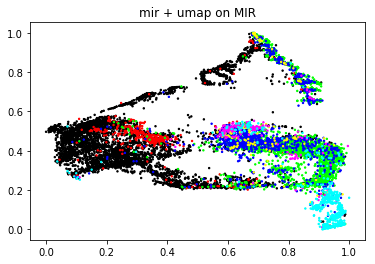

metric		 score
___________________________________
Silhouette	-0.080375237073
Roundess 	0.743041705102
Overlap  	0.166449130822
-----------------------------------
Final Score	0.829115598851


In [27]:
plot2D(mir_umap_embedding, colorMap, 'mir + umap', 'MIR')
scores = evalMetrics(mir_umap_embedding, y_data_labels)
printMetrics(scores)